<a href="https://colab.research.google.com/github/ShevchenkOksana/NLP/blob/main/NLP_Named_Entity_Recognition_(NER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets > /dev/null

In [ ]:
import sys
from typing import List, Tuple, Mapping

import datasets
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np

## Dataset

**[HuggingFace](https://huggingface.co/datasets/benjamin/ner-uk)** <br>
**[GitHub](https://github.com/lang-uk/ner-uk/tree/master)**

In [ ]:
dataset = datasets.load_dataset("benjamin/ner-uk")

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/10833 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1307 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/668 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10833
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1307
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 668
    })
})

In [ ]:
#dataset["test"][1]

In [ ]:
# NOTE: will be used for padding input sequences.
TOK_PAD_ID = 0

vocab = {"<PAD>": TOK_PAD_ID}
curr_idx = 1
for split in ("train", "validation", "test"):
    for sample in dataset[split]:
        for word in sample["tokens"]:
            if word not in vocab:
                vocab[word] = curr_idx
                curr_idx += 1

print("Vocab size:", len(vocab))

Vocab size: 50205


In [ ]:
# NOTE: will use this value for labels padding,
#       CrossEntropyLoss has special parameter called 'ignore_index'
#       and it will ignore labels with this value (loss computation
#       will be ommited for labels that equal to that value)
NER_PAD_ID = -100

targets = set()
for split in ("train", "validation", "test"):
    for sample in dataset[split]:
        targets.update(sample["ner_tags"])

targets = sorted(targets)
print("Unique targets:", len(targets))
targets

Unique targets: 9


[0, 1, 2, 3, 4, 5, 6, 7, 8]

## PyTorch Datasets & DataLoaders

In [ ]:
class NERDataset(Dataset):
    def __init__(self, samples: datasets.Dataset, vocabulary: Mapping[str, int]) -> None:
        self.samples = samples
        self.vocabulary = vocabulary

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        sample = self.samples[index]
        doc = torch.LongTensor([self.vocabulary[token] for token in sample["tokens"]])
        label = torch.LongTensor(sample["ner_tags"])
        return doc, label

In [ ]:
def seq_collate_fn(
    batch: List[Tuple[torch.LongTensor, torch.LongTensor]], data_pad: int, label_pad: int
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Combine samples into batch that can be used laten by RNN model.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).
        data_pad: value to use for padding text tokens.
        label_pad: value to use for padding label tokens.

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    token_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=data_pad)
    label_ids = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=label_pad)
    return token_ids, label_ids


def ner_collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Collator function for our NER dataset.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    return seq_collate_fn(batch, TOK_PAD_ID, NER_PAD_ID)

In [ ]:
train_dataset = NERDataset(dataset["train"], vocab)
validation_dataset = NERDataset(dataset["validation"], vocab)
test_dataset = NERDataset(dataset["test"], vocab)

len(train_dataset), len(validation_dataset), len(test_dataset)

(10833, 1307, 668)

In [ ]:
train_dataset[19]

(tensor([216, 217, 218, 219,  42, 220, 221, 222, 161, 223, 224,  61,  18]),
 tensor([0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

len(train_loader), len(validation_loader), len(test_loader)

(169, 21, 11)

In [ ]:
next(iter(train_loader))[1].shape

torch.Size([64, 92])

# Training & Evaluation

In [ ]:
def sequence_f1(true_labels: np.array, predicted_labels: np.array) -> np.array:
    """F1 score for one sequence.

    Args:
        true_labels: ground truth labels.
        predicted_labels: model predictions.

    Returns:
        F1 scores for each class.
    """
    assert len(true_labels) == len(predicted_labels), "Mismatched length between true labels and predicted labels"

    scores = []
    for _cls in targets:
        true_positives = np.sum((true_labels == predicted_labels) & (true_labels == _cls))
        false_positives = np.sum((true_labels != predicted_labels) & (predicted_labels == _cls))
        false_negatives = np.sum((true_labels != predicted_labels) & (true_labels == _cls))

        precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
        recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
        f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)

        scores.append(f1_score)
    return np.array(scores)

In [ ]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Train model one epoch.

    Args:
        model: model to train.
        loader: dataloader to use for training.
        criterion: loss function to optimize.
        optimizer: model training algorithm.
        device: device to use for training.
            Default is `"cpu"`.
        verbose: option to print training progress bar.
            Default is `True`.

    Returns:
        dict with training logs
    """
    model.train()

    losses = []
    scores = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)  # long tensor [B, T]
            y_true = y_true.to(device)    # long tensor [B, T]

            optimizer.zero_grad()

            log_prob = model(x_batch)

            B, T = y_true.shape
            loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))

            loss.backward()
            losses.append(loss.item())

            y_pred = log_prob.argmax(2).detach().cpu().numpy()
            y_true = y_true.detach().cpu().numpy()
            padding_mask = y_true != NER_PAD_ID
            for i in range(x_batch.size(0)):
                scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "f1": np.array(scores)
    }
    return logs

In [ ]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Model evaluation.

    Args:
        model: model to evaluate.
        loader: dataloader to use for evaluation.
        criterion: loss function.
        device: device to use for evaluation.
            Default is `"cpu"`.
        verbose: option to print evaluation progress bar.
            Default is `True`.

    Returns:
        dict with evaluation logs
    """
    model.eval()

    losses = []
    scores = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)  # long tensor [B, T]
        y_true = y_true.to(device)    # long tensor [B, T]

        log_prob = model(x_batch)

        B, T = y_true.shape
        loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))

        losses.append(loss.item())

        y_pred = log_prob.argmax(2).detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        padding_mask = y_true != NER_PAD_ID
        for i in range(x_batch.size(0)):
            scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))


    logs = {
        "losses": np.array(losses),
        "f1": np.array(scores)
    }
    return logs

## Modeling

In [ ]:
def test_model(n_epochs, model, show_res, device, lr, filename):
  train_losses = []
  train_scores = []

  valid_losses = []
  valid_scores = []

  best_score = float("-inf")
  optimizer = optim.Adam(model.parameters(), lr)
  criterion = nn.CrossEntropyLoss(ignore_index=-100)
  scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

  for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d} for {model.__class__.__name__}")

    train_logs = train_one_epoch(model, train_loader, criterion, optimizer, device, verbose=show_res)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    if show_res:
      print("      loss:", train_losses[-1])
      print("        f1:", train_scores[-1])


    valid_logs = evaluate(model, validation_loader, criterion, device, verbose=show_res)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    if show_res:
      print("      loss:", valid_losses[-1])
      print("        f1:", valid_scores[-1])

    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, filename)
        print("🟢 Saved new best state! 🟢")
        best_score = valid_scores[-1].mean()  # update best score to a new one

  # NOTE: plot training and validation performance
  fix, axes = plt.subplots(ncols=2, figsize=(22, 6))

  axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
  axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
  axes[0].legend(["train", "validation"])
  axes[0].set_title(f"Loss for Model: {model.__class__.__name__}, Epochs: {n_epochs}")
  axes[0].grid()

  axes[1].plot(np.arange(len(train_scores)), [item.mean() for item in train_scores], ".-")
  axes[1].plot(np.arange(len(valid_scores)), [item.mean() for item in valid_scores], ".-")
  axes[1].legend(["train", "validation"])
  axes[1].set_title(f"F1 for Model: {model.__class__.__name__}, Epochs: {n_epochs}")
  axes[1].grid();

In [ ]:
class NER_GRU(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_GRU, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.GRU(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)
        x = self.layer_norm(x)
        x = F.relu(x)
        x = self.fc(x)
        scores = torch.log_softmax(x, dim=2)
        return scores


class NER_LSTM(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_LSTM, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.LSTM(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)
        x = self.layer_norm(x)
        x = F.relu(x)
        x = self.fc(x)
        scores = torch.log_softmax(x, dim=2)
        return scores


class NER_RNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_RNN, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.RNN(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)
        x = self.layer_norm(x)
        x = F.relu(x)
        x = self.fc(x)
        scores = torch.log_softmax(x, dim=2)
        return scores

Device - cuda
NER_GRU(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 38317577

Epoch  1/30 for NER_GRU


<ipython-input-13-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-13-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-13-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


🟢 Saved new best state! 🟢

Epoch  2/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  3/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  4/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  5/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  6/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  7/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  8/30 for NER_GRU

Epoch  9/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 10/30 for NER_GRU

Epoch 11/30 for NER_GRU

Epoch 12/30 for NER_GRU

Epoch 13/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 14/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 15/30 for NER_GRU

Epoch 16/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 17/30 for NER_GRU

Epoch 18/30 for NER_GRU

Epoch 19/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 20/30 for NER_GRU

Epoch 21/30 for NER_GRU

Epoch 22/30 for NER_GRU

Epoch 23/30 for NER_GRU

Epoch 24/30 for NER_GRU

Epoch 25/30 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 26/30 for NER_GRU

Epoch 27/30 for NER_GRU

Epoch 28/30

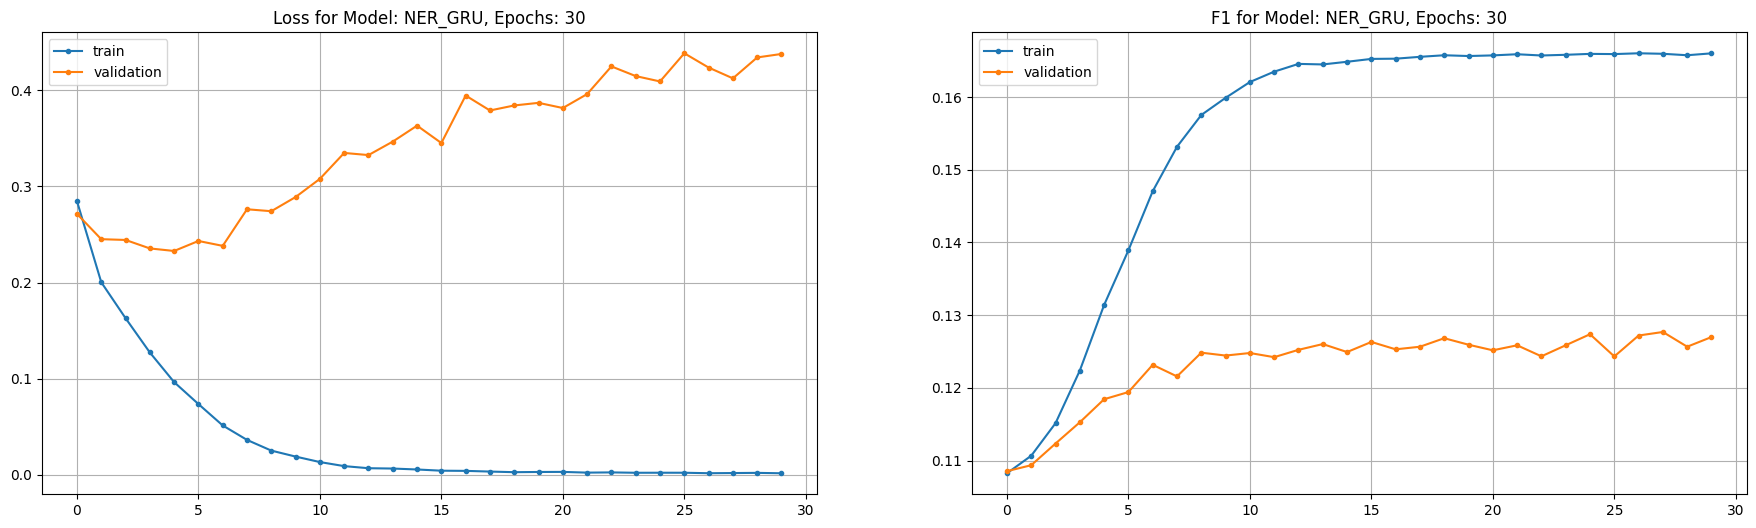

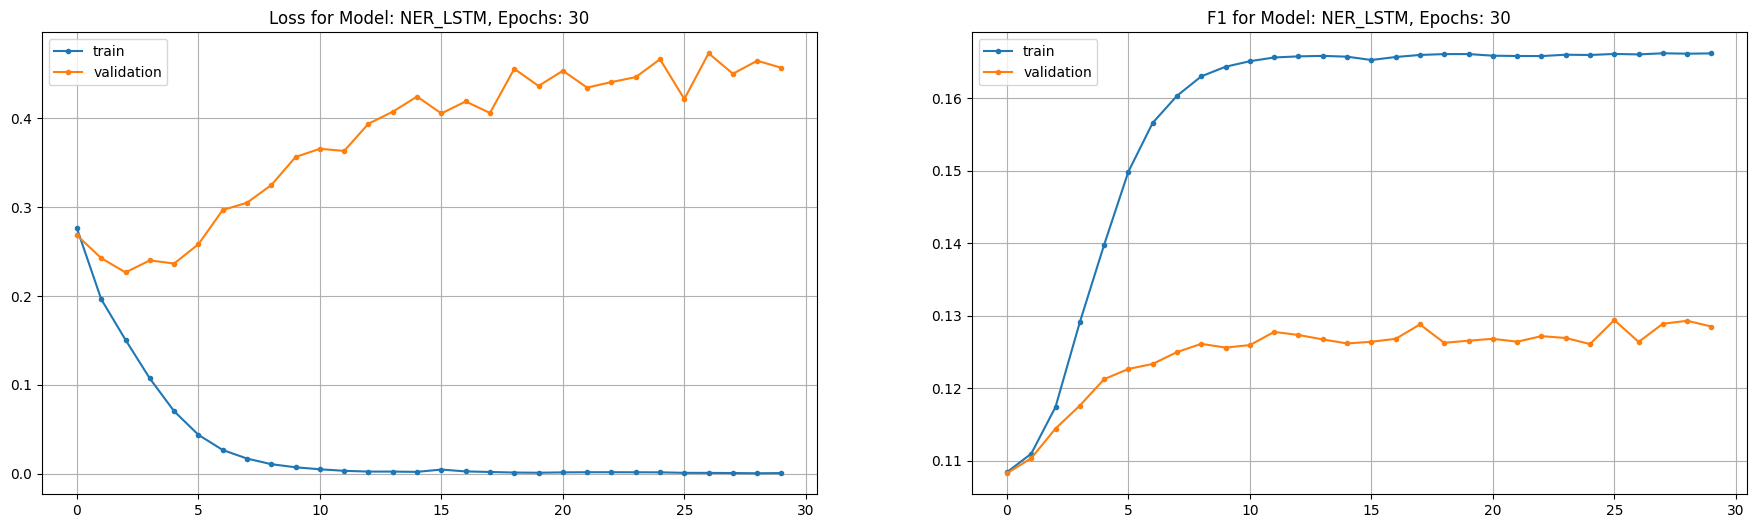

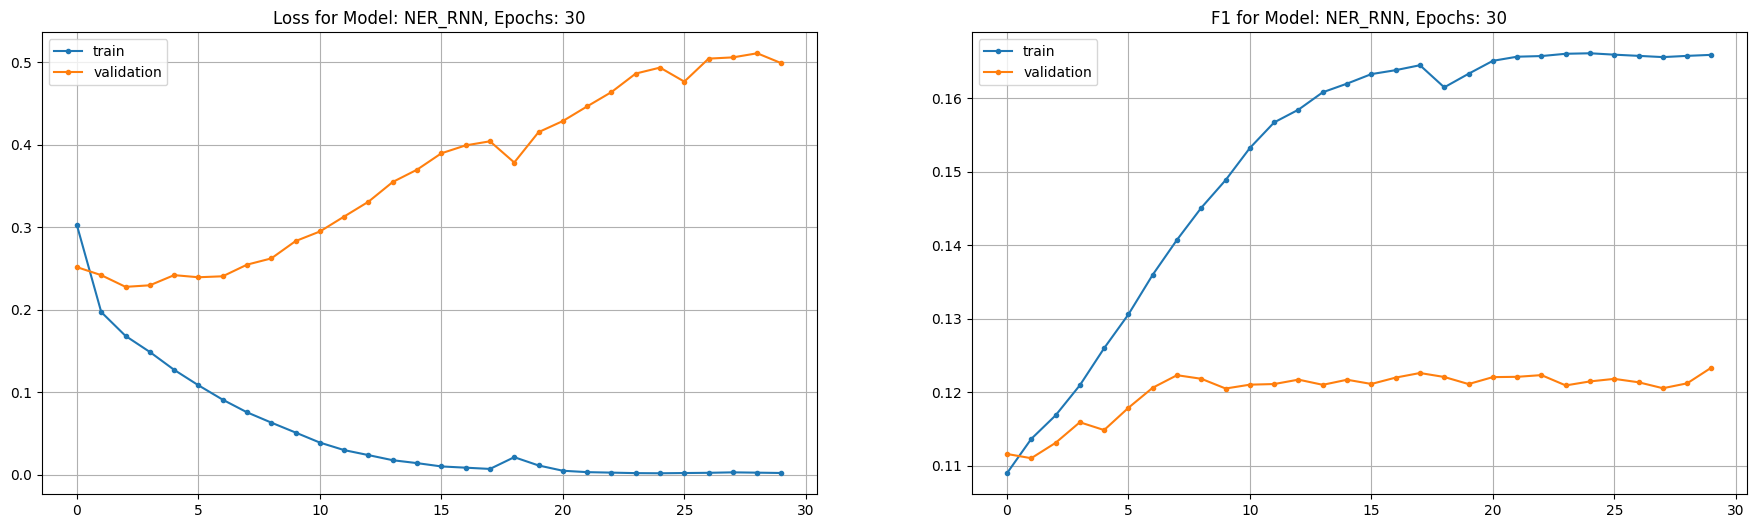

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

torch.manual_seed(42)

model_gru_30 = NER_GRU(len(vocab), 512, 512, 3, len(targets))
model_gru_30 = model_gru_30.to(device)
print(model_gru_30)
print("Number of trainable parameters -", sum(p.numel() for p in model_gru_30.parameters() if p.requires_grad))
test_model(30, model_gru_30, False, device, 1e-4, "best_gru_30.pth")


model_lstm_30 = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm_30 = model_lstm_30.to(device)
print(model_lstm_30)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm_30.parameters() if p.requires_grad))
test_model(30, model_lstm_30, False, device, 1e-4, "best_lstm_30.pth")


model_rnn_30 = NER_RNN(len(vocab), 512, 512, 3, len(targets))
model_rnn_30 = model_rnn_30.to(device)
print(model_rnn_30)
print("Number of trainable parameters -", sum(p.numel() for p in model_rnn_30.parameters() if p.requires_grad))
test_model(30, model_rnn_30, False, device, 1e-4, "best_rnn_30.pth")

In [ ]:
#######################################################################
# TODO: load model best state # done
#######################################################################

def load_best_model_state(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])

    # Set the precision globally for NumPy arrays
    np.set_printoptions(precision=4)

    metrics = checkpoint["metrics"]
    print(f"Loaded the best model {model.__class__.__name__} from epoch {checkpoint['epoch']} with metrics:")
    print("  Training Loss:", metrics["training"]["loss"])
    print("  Training F1:", metrics["training"]["accuracy"])
    print()
    print("  Validation Loss:", metrics["validation"]["loss"])
    print("  Validation F1:", metrics["validation"]["accuracy"])
    print()
    print()

    return metrics["validation"]["accuracy"]

In [ ]:
best_score_gru = load_best_model_state(model_gru_30, "best_gru_30.pth")
best_score_lstm = load_best_model_state(model_lstm_30, "best_lstm_30.pth")
best_score_rnn = load_best_model_state(model_rnn_30, "best_rnn_30.pth")

Loaded the best model NER_GRU from epoch 27 with metrics:
  Training Loss: 0.0017867568760546139
  Training F1: [0.9998 0.2243 0.0478 0.0361 0.0242 0.084  0.0208 0.0364 0.0204]

  Validation Loss: 0.41244121499004816
  Validation F1: [0.9811 0.0976 0.0175 0.015  0.0045 0.0188 0.0013 0.008  0.0055]


Loaded the best model NER_LSTM from epoch 25 with metrics:
  Training Loss: 0.0011481689639663676
  Training F1: [0.9999 0.225  0.0477 0.0363 0.0243 0.0845 0.0207 0.0364 0.0205]

  Validation Loss: 0.4214882006247838
  Validation F1: [0.9806 0.111  0.0196 0.0129 0.0064 0.0244 0.0025 0.0051 0.0023]


Loaded the best model NER_RNN from epoch 29 with metrics:
  Training Loss: 0.002102728591255083
  Training F1: [0.9997 0.2231 0.0473 0.0364 0.0243 0.0843 0.0209 0.0365 0.0204]

  Validation Loss: 0.49863044491836
  Validation F1: [0.974  0.0819 0.0105 0.0152 0.0059 0.0129 0.0019 0.0041 0.004 ]




Device - cuda
NER_GRU(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 38317577

Epoch  1/50 for NER_GRU


<ipython-input-13-9702e04ccc39>:19: RuntimeWarning: invalid value encountered in long_scalars
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-13-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)
<ipython-input-13-9702e04ccc39>:20: RuntimeWarning: invalid value encountered in long_scalars
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)


🟢 Saved new best state! 🟢

Epoch  2/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  3/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  4/50 for NER_GRU

Epoch  5/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  6/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  7/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  8/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch  9/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 10/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 11/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 12/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 13/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 14/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 15/50 for NER_GRU

Epoch 16/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 17/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 18/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 19/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 20/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch 21/50 for NER_GRU
🟢 Saved new best state! 🟢

Epoch

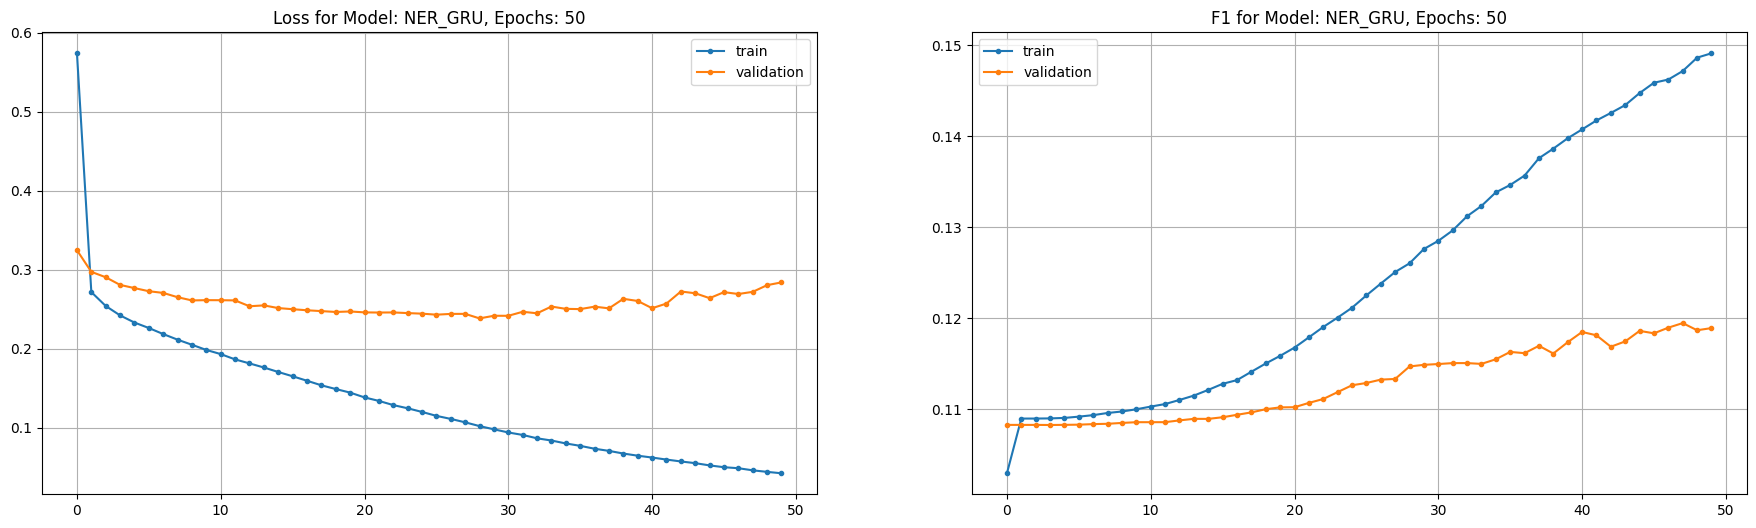

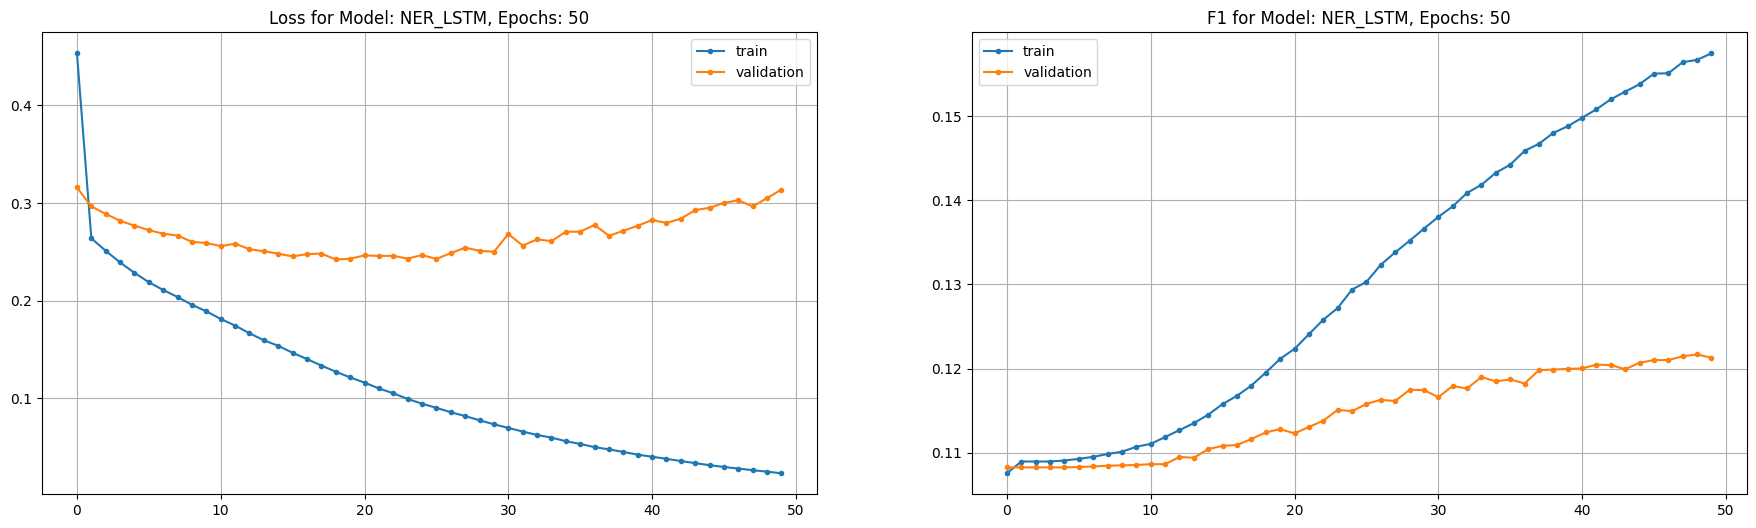

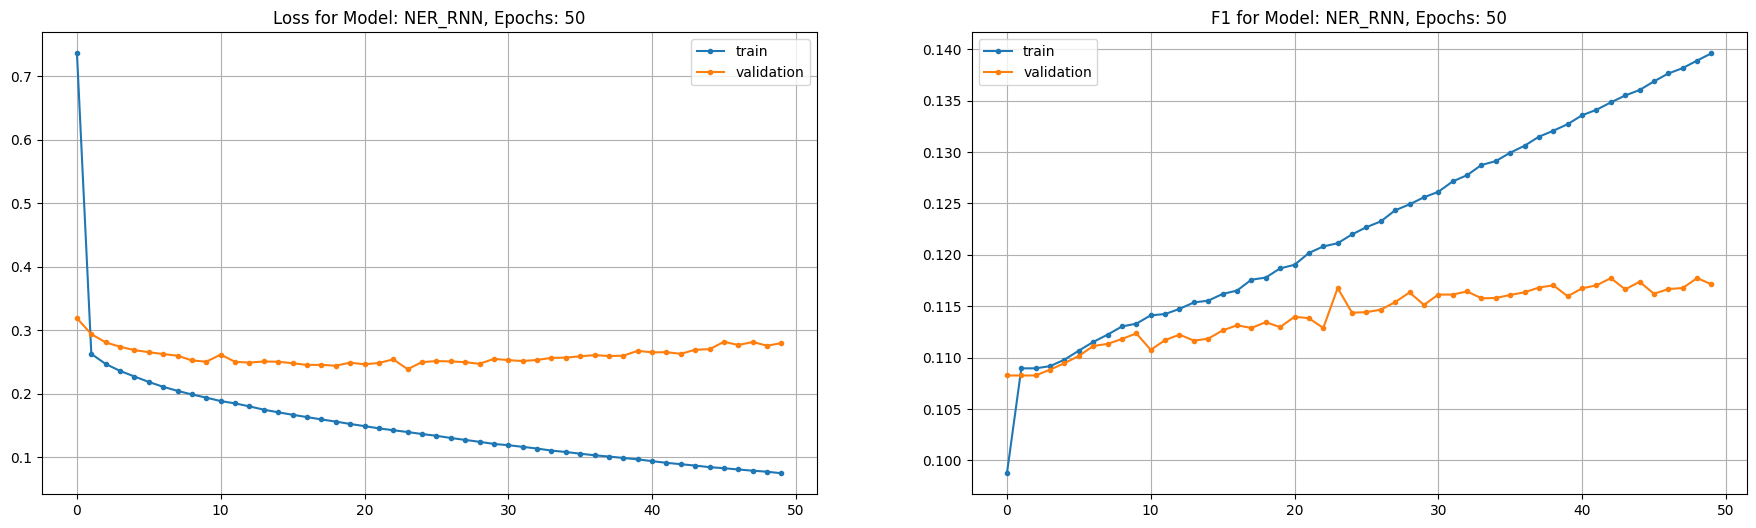

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

torch.manual_seed(42)
n= 50
learn_rate = 1e-5

model_gru = NER_GRU(len(vocab), 512, 512, 3, len(targets))
model_gru = model_gru.to(device)
print(model_gru)
print("Number of trainable parameters -", sum(p.numel() for p in model_gru.parameters() if p.requires_grad))
test_model(n, model_gru, False, device, learn_rate, "best_gru_50.pth")


model_lstm = NER_LSTM(len(vocab), 512, 512, 3, len(targets))
model_lstm = model_lstm.to(device)
print(model_lstm)
print("Number of trainable parameters -", sum(p.numel() for p in model_lstm.parameters() if p.requires_grad))
test_model(n, model_lstm, False, device, learn_rate, "best_lstm_50.pth")


model_rnn = NER_RNN(len(vocab), 512, 512, 3, len(targets))
model_rnn = model_rnn.to(device)
print(model_rnn)
print("Number of trainable parameters -", sum(p.numel() for p in model_rnn.parameters() if p.requires_grad))
test_model(n, model_rnn, False, device, learn_rate, "best_rnn_50.pth")

In [ ]:
best_score_gru_50 = load_best_model_state(model_gru, "best_gru_50.pth")
best_score_lstm_50 = load_best_model_state(model_lstm, "best_lstm_50.pth")
best_score_rnn_50 = load_best_model_state(model_rnn, "best_rnn_50.pth")

Loaded the best model NER_GRU from epoch 47 with metrics:
  Training Loss: 0.04632801257250224
  Training F1: [0.994  0.1579 0.0294 0.0213 0.0202 0.0521 0.0107 0.0206 0.0179]

  Validation Loss: 0.2721751885754721
  Validation F1: [0.9785 0.061  0.0094 0.0079 0.0045 0.0087 0.0013 0.0026 0.0013]


Loaded the best model NER_LSTM from epoch 48 with metrics:
  Training Loss: 0.02500960669485775
  Training F1: [0.9969 0.1984 0.0402 0.0272 0.0224 0.0652 0.0146 0.0266 0.0186]

  Validation Loss: 0.30501708743118106
  Validation F1: [0.979  0.0645 0.0143 0.0071 0.0076 0.013  0.0019 0.0028 0.005 ]


Loaded the best model NER_RNN from epoch 48 with metrics:
  Training Loss: 0.07701395498313142
  Training F1: [0.9902 0.1134 0.0265 0.0204 0.0182 0.0395 0.0099 0.0172 0.0149]

  Validation Loss: 0.2755915339858759
  Validation F1: [0.976  0.0446 0.0078 0.0072 0.0055 0.0105 0.001  0.0042 0.0028]




In [ ]:
#######################################################################
# TODO: write evaluation function for a test set. #done
#######################################################################
def evaluate_model(model, dataloader, device, targets):
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs.permute(0, 2, 1), labels)

            # Accumulate loss
            total_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, dim=2)  # Assuming class probabilities along dim=2

            # Collect predictions and labels
            all_predictions.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate F1 score for each class
    f1_scores = sequence_f1(np.array(all_labels), np.array(all_predictions))

    # Calculate average loss
    loss = total_loss / len(dataloader)
    print(f"For Model: {model.__class__.__name__}")
    print(f"Test F1 Scores for each class: {f1_scores}")
    print(f"Average Test Loss: {loss:.4f}")
    print()

    return f1_scores, loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f1_gru_50, loss_gru_50 = evaluate_model(model_gru, test_loader, device, targets)
f1_lstm_50, loss_lstm_50 = evaluate_model(model_lstm, test_loader, device, targets)
f1_rnn_50, loss_rnn_50 = evaluate_model(model_rnn, test_loader, device, targets)

For Model: NER_GRU
Test F1 Scores for each class: [0.4074 0.2891 0.1495 0.1935 0.15   0.314  0.1333 0.3529 0.1892]
Average Test Loss: 0.2730

For Model: NER_LSTM
Test F1 Scores for each class: [0.4074 0.3229 0.2373 0.2222 0.3333 0.3594 0.1333 0.2051 0.275 ]
Average Test Loss: 0.3136

For Model: NER_RNN
Test F1 Scores for each class: [0.4219 0.1892 0.193  0.1846 0.0102 0.2479 0.     0.2985 0.1299]
Average Test Loss: 0.2658



<ipython-input-13-9702e04ccc39>:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


Was testing next models:

   * GRU
   * LSTM
   * RNN

Used the following parameters:
   * batch size 64
   * learning rate first was 0.0001, then 0.00001
   * epochs first was 30, then increase to 50  

Models show the following results:

*GRU, epoch 47*

    Validation Loss: 0.2721751885754721
    Validation F1: [0.9785 0.061  0.0094 0.0079 0.0045 0.0087 0.0013 0.0026 0.0013]
    Average Test Loss: 0.2730


*LSTM, epoch 48*

    Validation Loss: 0.30501708743118106
    Validation F1: [0.979  0.0645 0.0143 0.0071 0.0076 0.013  0.0019 0.0028 0.005 ]
    Average Test Loss: 0.3136


*RNN, epoch 48*

    Validation Loss: 0.2755915339858759
    Validation F1: [0.976  0.0446 0.0078 0.0072 0.0055 0.0105 0.001  0.0042 0.0028]
    Average Test Loss: 0.2658

The best result on the test data is shown by the RNN model; however, it has a worse validation loss than the GRU model.


